## GlucoTrack Project, Week 4: Neural Networks v Simpler Models

Objective: to work with a real-world CDC dataset and build a complete pipeline from data preprocessing to deployment using tools like PyTorch/TensorFlow, SHAP, and MLflow to glean insight for Diabetes risk factors.

Source: CDC Diabetes Health Indicators
- Outcome variable: Individuals are classified as diabetic (1) or non-diabetic (0)
- Features: Health, lifestyle, and demographic indicators. 
- All responses were obtained from phone surveys conducted as part of the CDC Behavioral Risk Factor Surveillance System (BRFSS). 
- Few questions represent objective lab measurements (cholesterol, high blood pressure); most are subjective measures of self-assessed health and lifestyle factors. 
- From the UCI repo, it looks like the data was collected in 2014
- Data collection methods can be found here and are an important part of the context of the representative nature of the potential findings to the general population:
https://www.cdc.gov/brfss/annual_data/2014/pdf/Overview_2014.pdf

I have built a feed forward neural network to attempt to predict the features from the dataset associated with the risk of a diabetes diagnosis. The model performance overall was poor, although the recall metric was fairly good and resulted in the top features being associated with clinically relevant results.

I would now like to contrast those results with a simpler model.

In [17]:
import streamlit as st
import pickle
import torch
import mlflow
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# Suppress specific warning categories
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='.*caveats.*')

# Suppress pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

print(f"Libraries imported successfully!")
print(f"MLflow version: {mlflow.__version__}")

Libraries imported successfully!
MLflow version: 3.2.0


## **I need to import the results from Week 4 FFNN and SHAP for complete comparison**

In [5]:
print("🔄 Loading FFNN model and results from SHAP notebook...")
%run -i gluco-track-week4-SHAP.ipynb

# Now the FFNN variables should be available
print(f"✅ FFNN variables loaded:")
print(f"   best_val_f1: {best_val_f1:.4f}")
print(f"   Test metrics - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

🔄 Loading FFNN model and results from SHAP notebook...


c:\Users\novem\OneDrive\Documents\TheDen\Career\SuperDataScience\gluco_track\SDS-CP035-gluco-track\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0
=== LOADING DATA FROM WEEK 2 ===
Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
MLflow version: 3.2.0
SHAP version: 0.48.0
Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB
=== DUPLICATE ROWS ===
Original dataset rows: 253680
Unique observations: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset rows: 229474
Rows removed: 24206
=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimized to uint8 (range: 0-1)
  

PermutationExplainer explainer: 201it [00:12,  7.24it/s]                         


✅ SHAP analysis completed!
SHAP values shape: (200, 21)
Creating SHAP summary plot...
Creating SHAP bar plot...
Creating SHAP waterfall plot for first prediction...
=== INTERPRETING RED POINTS LEFT OF ZERO ===

Smoker:
  High values reducing diabetes risk: 87 cases
  Average SHAP when feature is high: -0.039
  Clinical interpretation: Higher Smoker → Lower diabetes risk

Stroke:
  High values reducing diabetes risk: 9 cases
  Average SHAP when feature is high: -0.100
  Clinical interpretation: Higher Stroke → Lower diabetes risk

HeartDiseaseorAttack:
  High values reducing diabetes risk: 14 cases
  Average SHAP when feature is high: -0.011
  Clinical interpretation: Higher HeartDiseaseorAttack → Lower diabetes risk

HvyAlcoholConsump:
  High values reducing diabetes risk: 14 cases
  Average SHAP when feature is high: -0.218
  Clinical interpretation: Higher HvyAlcoholConsump → Lower diabetes risk
✅ FFNN variables loaded:
   best_val_f1: 0.4299
   Test metrics - Acc: 0.6948, Prec: 0.29

## **Model Training and Evaluation Loop**

In [9]:
# === MODEL COMPARISON: NEURAL NETWORK VS SIMPLER MODELS ===
# Set up the MLflow experiment
mlflow.set_experiment("Diabetes_Baseline_Models_Comparison")

# Define a dictionary of models to train
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Store results for comparison
results = []

print("=== TRAINING AND EVALUATING BASELINE MODELS ===\n")

# First, add your FFNN results from the imported variables
print("🔄 Adding FFNN results to comparison...")

# Calculate missing validation metrics for FFNN
model.eval()
y_val_pred_ffnn = []
y_val_prob_ffnn = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        outputs = outputs.unsqueeze(1) if outputs.dim() == 1 else outputs
        y_val_prob_ffnn.extend(outputs.cpu().numpy().flatten())
        y_val_pred_ffnn.extend((outputs.cpu().numpy().flatten() > 0.5).astype(int))

# Create FFNN results dictionary
ffnn_results = {
    'Model': 'Feed Forward Neural Network',
    'Val_Accuracy': accuracy_score(y_val, y_val_pred_ffnn),
    'Val_Precision': precision_score(y_val, y_val_pred_ffnn),
    'Val_Recall': recall_score(y_val, y_val_pred_ffnn),
    'Val_F1': f1_score(y_val, y_val_pred_ffnn),
    'Val_AUC': roc_auc_score(y_val, y_val_prob_ffnn),
    'Test_Accuracy': acc,
    'Test_Precision': prec,
    'Test_Recall': rec,
    'Test_F1': f1,
    'Test_AUC': auc
}

# Add FFNN results to the results list
results.append(ffnn_results)

print(f"--- Feed Forward Neural Network Results ---")
print(f"Validation - Accuracy: {ffnn_results['Val_Accuracy']:.4f}, Precision: {ffnn_results['Val_Precision']:.4f}, Recall: {ffnn_results['Val_Recall']:.4f}, F1: {ffnn_results['Val_F1']:.4f}, AUC: {ffnn_results['Val_AUC']:.4f}")
print(f"Test - Accuracy: {ffnn_results['Test_Accuracy']:.4f}, Precision: {ffnn_results['Test_Precision']:.4f}, Recall: {ffnn_results['Test_Recall']:.4f}, F1: {ffnn_results['Test_F1']:.4f}, AUC: {ffnn_results['Test_AUC']:.4f}")
print()

# Loop through each traditional ML model to train, evaluate, and log with MLflow
for model_name, model_instance in models.items():
    print(f"🔄 Training {model_name}...")
    
    # Start a new MLflow run for each model
    with mlflow.start_run(run_name=f"{model_name}_baseline"):
        
        # Train the model on the training data
        model_instance.fit(X_train_scaled, y_train_resampled)

        # Make predictions on validation and test sets
        y_val_pred = model_instance.predict(X_val_scaled)
        y_test_pred = model_instance.predict(X_test_scaled)
        
        # Get prediction probabilities for AUC calculation
        if hasattr(model_instance, "predict_proba"):
            y_val_prob = model_instance.predict_proba(X_val_scaled)[:, 1]
            y_test_prob = model_instance.predict_proba(X_test_scaled)[:, 1]
        else:
            # For models without predict_proba, use decision_function or predictions
            y_val_prob = y_val_pred
            y_test_prob = y_test_pred

        # Calculate validation metrics
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_prob) if len(np.unique(y_val_prob)) > 1 else 0.5

        # Calculate test metrics
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_prob) if len(np.unique(y_test_prob)) > 1 else 0.5

        # Log model parameters and metrics to MLflow
        mlflow.log_params(model_instance.get_params())
        
        # Log validation metrics
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)
        mlflow.log_metric("val_f1_score", val_f1)
        mlflow.log_metric("val_auc", val_auc)
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_f1_score", test_f1)
        mlflow.log_metric("test_auc", test_auc)

        # Create and save confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f"confusion_matrix_{model_name.replace(' ', '_').lower()}.png")
        mlflow.log_artifact(f"confusion_matrix_{model_name.replace(' ', '_').lower()}.png")
        plt.close()

        # Store results for comparison table
        results.append({
            'Model': model_name,
            'Val_Accuracy': val_accuracy,
            'Val_Precision': val_precision,
            'Val_Recall': val_recall,
            'Val_F1': val_f1,
            'Val_AUC': val_auc,
            'Test_Accuracy': test_accuracy,
            'Test_Precision': test_precision,
            'Test_Recall': test_recall,
            'Test_F1': test_f1,
            'Test_AUC': test_auc
        })

        # Print results
        print(f"--- {model_name} Results ---")
        print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")
        print()

print("✅ All models trained and evaluated!")

=== TRAINING AND EVALUATING BASELINE MODELS ===

🔄 Adding FFNN results to comparison...
--- Feed Forward Neural Network Results ---
Validation - Accuracy: 0.6912, Precision: 0.2953, Recall: 0.7349, F1: 0.4213, AUC: 0.7764
Test - Accuracy: 0.6875, Precision: 0.2944, Recall: 0.7473, F1: 0.4224, AUC: 0.7764

🔄 Training Logistic Regression...
--- Logistic Regression Results ---
Validation - Accuracy: 0.7060, Precision: 0.3025, Recall: 0.7061, F1: 0.4236, AUC: 0.7739
Test - Accuracy: 0.6994, Precision: 0.2976, Recall: 0.7099, F1: 0.4194, AUC: 0.7746

🔄 Training Decision Tree...
--- Decision Tree Results ---
Validation - Accuracy: 0.7189, Precision: 0.2490, Recall: 0.4155, F1: 0.3114, AUC: 0.5975
Test - Accuracy: 0.7155, Precision: 0.2455, Recall: 0.4149, F1: 0.3084, AUC: 0.5954

🔄 Training Random Forest...
--- Random Forest Results ---
Validation - Accuracy: 0.7667, Precision: 0.3160, Recall: 0.4511, F1: 0.3717, AUC: 0.7430
Test - Accuracy: 0.7662, Precision: 0.3171, Recall: 0.4586, F1: 0.3

=== MODEL COMPARISON SUMMARY ===

Validation Set Performance:
                         Model  Val_Accuracy  Val_Precision  Val_Recall  \
0  Feed Forward Neural Network        0.6912         0.2953      0.7349   
1          Logistic Regression        0.7060         0.3025      0.7061   
2                Decision Tree        0.7189         0.2490      0.4155   
3                Random Forest        0.7667         0.3160      0.4511   
4                  Naive Bayes        0.5950         0.2515      0.8338   

   Val_F1  Val_AUC  
0  0.4213   0.7764  
1  0.4236   0.7739  
2  0.3114   0.5975  
3  0.3717   0.7430  
4  0.3864   0.7571  

Test Set Performance:
                         Model  Test_Accuracy  Test_Precision  Test_Recall  \
0  Feed Forward Neural Network         0.6875          0.2944       0.7473   
1          Logistic Regression         0.6994          0.2976       0.7099   
2                Decision Tree         0.7155          0.2455       0.4149   
3                Random Fo

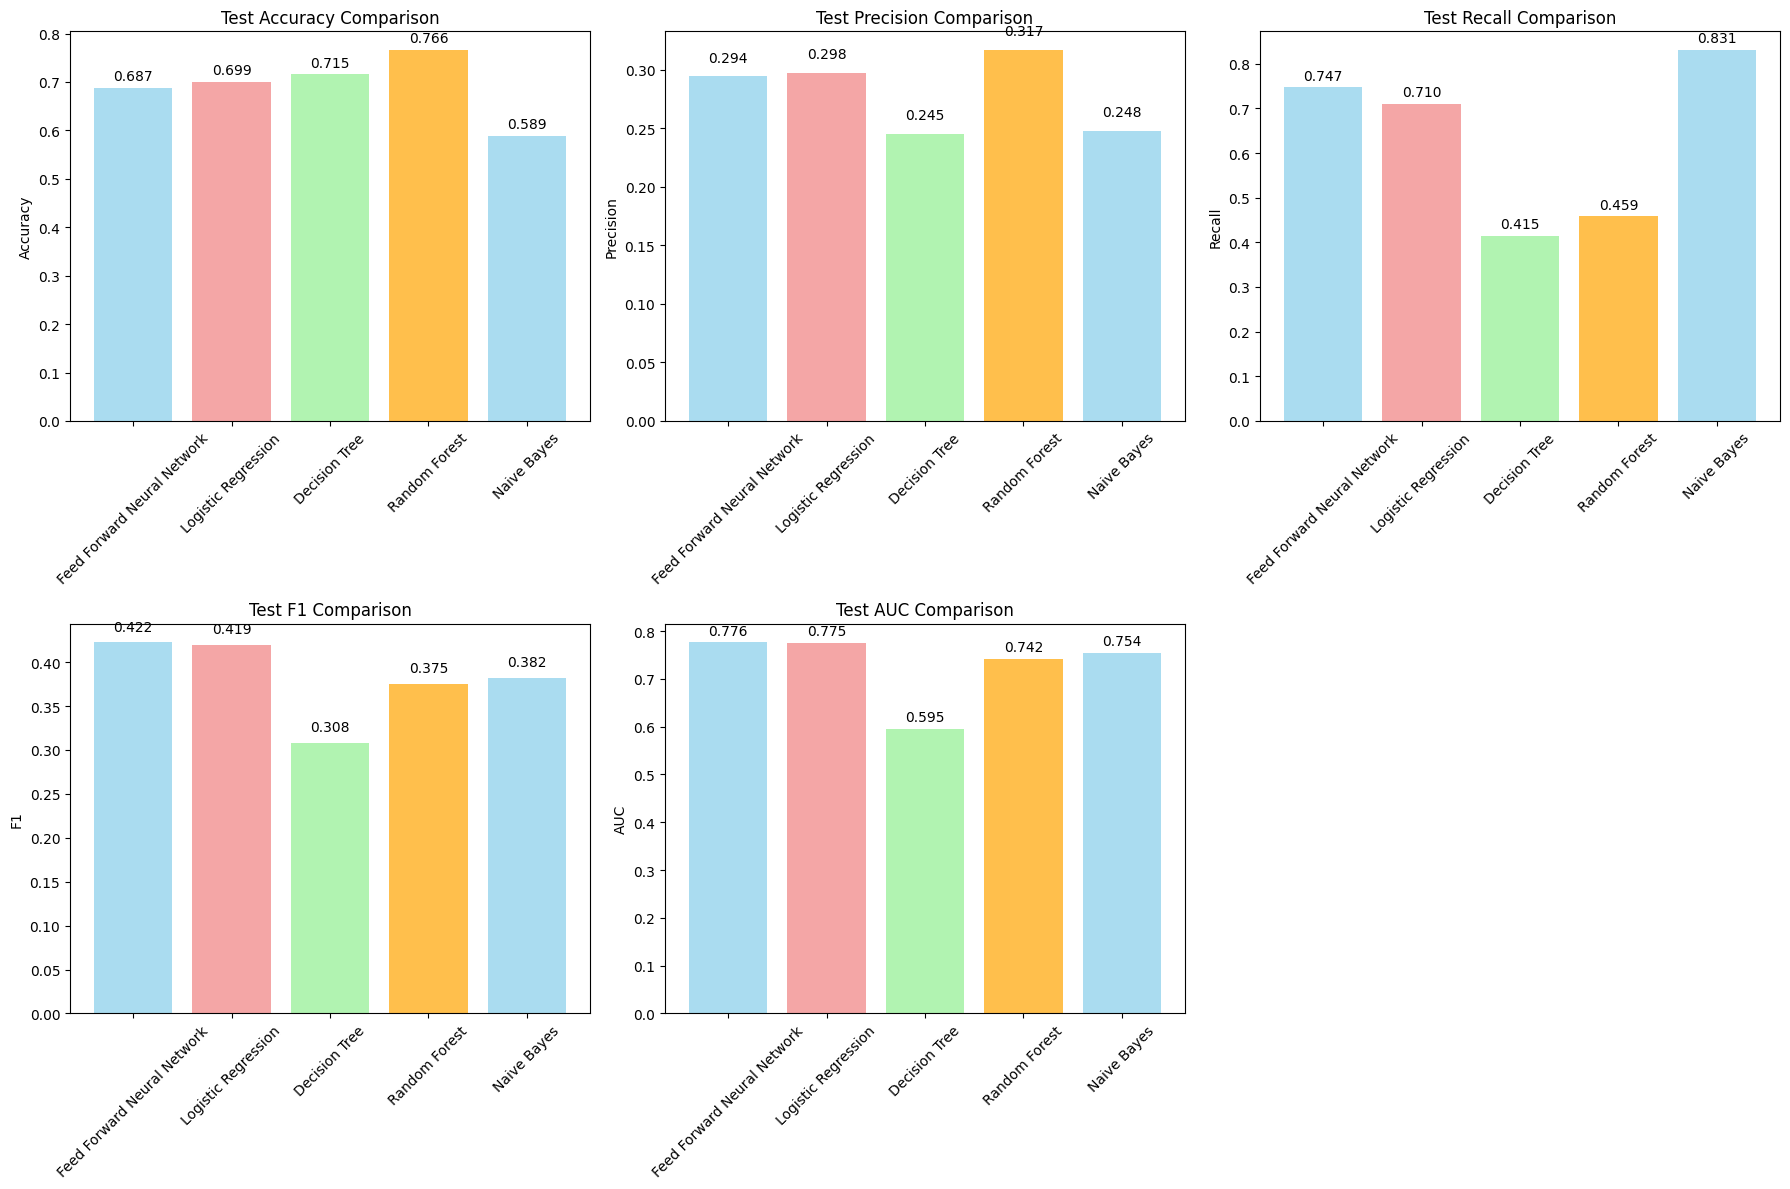


=== BEST PERFORMING MODELS BY METRIC ===
Accuracy: Random Forest (0.7662)
Precision: Random Forest (0.3171)
Recall: Naive Bayes (0.8310)
F1: Feed Forward Neural Network (0.4224)
AUC: Feed Forward Neural Network (0.7764)


In [10]:
# === MODEL COMPARISON ANALYSIS ===

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)

print("=== MODEL COMPARISON SUMMARY ===")
print("\nValidation Set Performance:")
print(comparison_df[['Model', 'Val_Accuracy', 'Val_Precision', 'Val_Recall', 'Val_F1', 'Val_AUC']].round(4))

print("\nTest Set Performance:")
print(comparison_df[['Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']].round(4))

# Save comparison results
comparison_df.to_csv("model_comparison_results.csv", index=False)

# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
test_metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']

for i, (metric, test_metric) in enumerate(zip(metrics, test_metrics)):
    row = i // 3
    col = i % 3
    
    ax = axes[row, col]
    
    # Create bar plot for each metric
    models_list = comparison_df['Model'].tolist()
    values = comparison_df[test_metric].tolist()
    
    bars = ax.bar(models_list, values, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
    ax.set_title(f'Test {metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.savefig("model_comparison_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# Identify best model for each metric
print("\n=== BEST PERFORMING MODELS BY METRIC ===")
for metric in test_metrics:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"{metric.replace('Test_', '')}: {best_model} ({best_score:.4f})")


=== FEATURE IMPORTANCE ANALYSIS ===

--- Top 10 Features: Decision Tree ---
         feature  importance
12       GenHlth    0.128983
17           Age    0.128702
19        Income    0.100370
14      PhysHlth    0.091434
18     Education    0.074067
13      MentHlth    0.069940
20  bmi_category    0.063248
0         HighBP    0.057035
16           Sex    0.036179
1       HighChol    0.034667


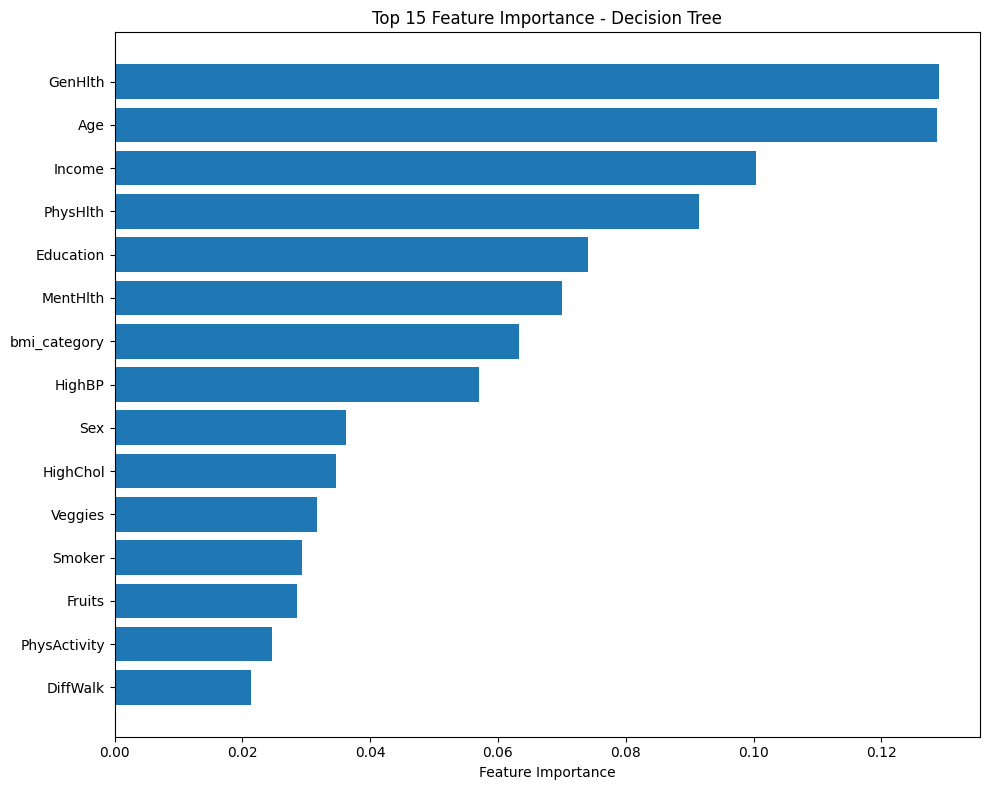


--- Top 10 Features: Random Forest ---
         feature  importance
17           Age    0.165344
19        Income    0.109852
12       GenHlth    0.094003
14      PhysHlth    0.091989
20  bmi_category    0.079904
18     Education    0.071952
13      MentHlth    0.066785
0         HighBP    0.052439
16           Sex    0.031355
3         Smoker    0.029831


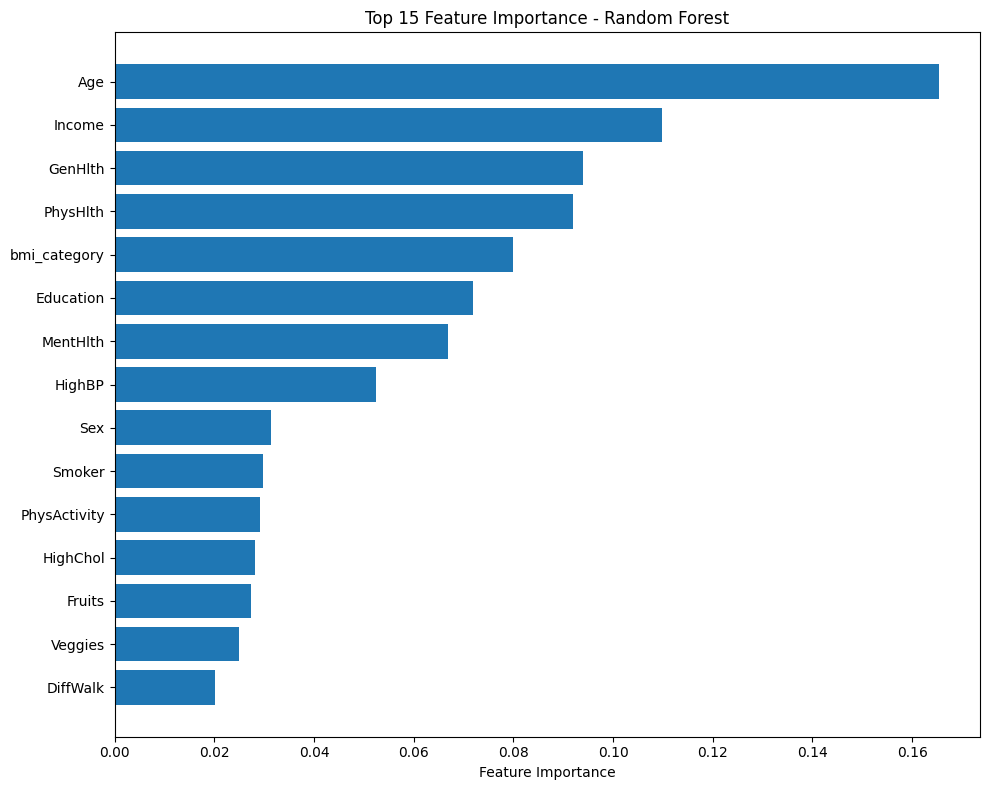


--- Top 10 Features: Logistic Regression ---
              feature  importance
9   HvyAlcoholConsump    2.072964
2           CholCheck    1.178637
11        NoDocbcCost    1.040632
4              Stroke    0.677757
0              HighBP    0.595449
12            GenHlth    0.454715
15           DiffWalk    0.394764
1            HighChol    0.383473
6        PhysActivity    0.361978
7              Fruits    0.343378


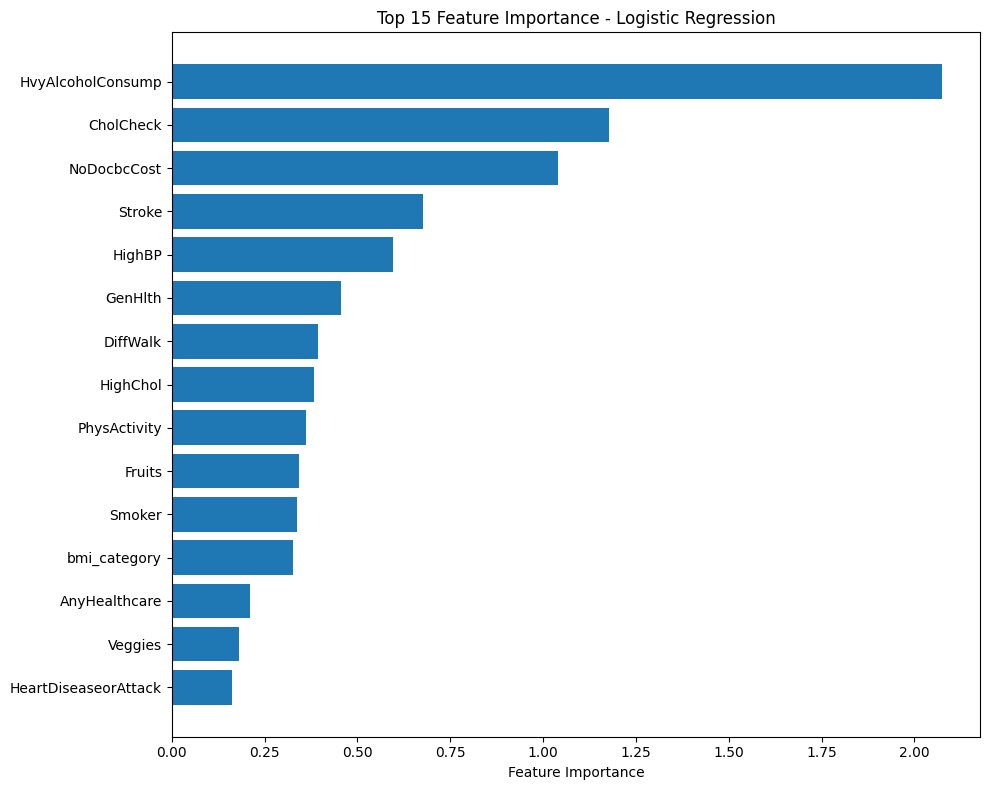


✅ Model comparison and feature importance analysis completed!


In [11]:
# === FEATURE IMPORTANCE ANALYSIS (for tree-based models) ===

print("\n=== FEATURE IMPORTANCE ANALYSIS ===")

# Train models to get feature importance
feature_importance_models = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

feature_names = X_train_scaled.columns.tolist()

for model_name, model in feature_importance_models.items():
    model.fit(X_train_scaled, y_train_resampled)
    
    if hasattr(model, 'feature_importances_'):
        # Tree-based models
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Linear models - use absolute coefficients
        importances = np.abs(model.coef_[0])
    else:
        continue
    
    # Create feature importance DataFrame
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\n--- Top 10 Features: {model_name} ---")
    print(feature_imp_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_imp_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"feature_importance_{model_name.replace(' ', '_').lower()}.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n✅ Model comparison and feature importance analysis completed!")

# **SUMMARY**

=== BEST PERFORMING MODELS BY METRIC ===

- Accuracy: Random Forest (0.7662)
- Precision: Random Forest (0.3171)
- Recall: Naive Bayes (0.8310)
- F1: Feed Forward Neural Network (0.4224)
- AUC: Feed Forward Neural Network (0.7764)

=== TOP FEATURES PREDICTING DIABETES RISK COMMON TO MOST ===

- General Health (1-5), Age, BMI (WHO category), High Blood Pressure, Income

Although the FFNN metrics indicate less than optimal performance, it had the highest F1 and AUC of all models.  Its Accuracy and Precision were slightly less than Random Forest.  The ranking of the predictive features from Random Forest are similar to FFNN/SHAP and Decision Tree, and may reflect a relevant clinical point of view.  Although BMI is a known risk factor for diabetes (and ranks in the top 8 for FFNN, Decision Tree and Random Forest), it is well known that lower BMI is not necessarily protective against diabetes.

The logistic regression model performed among the highest in all metrics.  However, the ranking of the predictive features was substantially different than all other models and conformed the least to a clinical perspective, with Heavy Alcohol Use ranking as the highest feature, and with BMI ranking near the bottom.

While additional hyperparameter tuning could be done, I suspect from the work shared by team members that this would not make a significant difference to these outcomes.  It may be more effective to do some feature selection to remove features with lesser importance.  It may be valuable to combine two or more features to capture relationships that individual features cannot. For example, the health risk from a high BMI might be much greater for an older person than a younger one. We may also have inherent limitations of this dataset in regard to known underlying risk factors that were not included or adequately measured. I did not attempt Gradient Boosting models, which are adept at finding complex patterns. 

Finally, it is worth considering the use case for this data set.  A data set that had included more rigorous survey techniques and use of measured clinical data may have provided valuable insights into health factors associated with diabetes risks and outcomes that could impact health policy and interventions.  Nevertheless, this data set utilized existing health survey data that employed simple responses.  As such, it is encouraging that it provided the ability to yield clinically relevant findings in spite of the biases and limitations.

## **Prepare components for Streamlit application**

In [16]:
print("=== SAVING MODEL COMPONENTS FOR STREAMLIT APP ===")

# 1. Save the trained model
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model state dict saved as 'best_model.pth'")

# 2. Create a COMPLETE preprocessing pipeline that matches your training process
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Define the continuous columns that need scaling
continuous_cols = ['MentHlth', 'PhysHlth']

# Create a preprocessing pipeline that handles all features
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), continuous_cols),  # Scale only continuous features
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in continuous_cols])  # Keep other features as-is
    ],
    remainder='passthrough'  # Keep any remaining columns
)

# Fit the preprocessor on the original training data (before SMOTE)
preprocessor.fit(X_train)

# Save the complete preprocessor
import pickle
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("✅ Complete preprocessor saved as 'preprocessor.pkl'")

# 3. Save feature names (in the correct order after preprocessing)
# Get feature names after transformation
feature_names = (continuous_cols + 
                [col for col in X_train.columns if col not in continuous_cols])
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✅ Feature names saved as 'feature_names.pkl'")

# 4. Save model architecture parameters
model_config = {
    'input_size': len(X_train.columns),  # All features
    'hidden_size': 64,  # Update this to match your actual model
    'dropout_rate': model.net[3].p if hasattr(model.net[3], 'p') else 0.3,  # Extract from your model
    'output_size': 1
}
with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✅ Model configuration saved as 'model_config.pkl'")

# 5. Save background data for SHAP (use properly preprocessed data)
background_sample = X_train_scaled.sample(n=100, random_state=42)
with open('shap_background.pkl', 'wb') as f:
    pickle.dump(background_sample.values, f)
print("✅ SHAP background data saved as 'shap_background.pkl'")

# 6. Save feature statistics for validation
feature_stats = {
    'means': X_train_scaled.mean().to_dict(),
    'stds': X_train_scaled.std().to_dict(),
    'mins': X_train_scaled.min().to_dict(),
    'maxs': X_train_scaled.max().to_dict()
}
with open('feature_stats.pkl', 'wb') as f:
    pickle.dump(feature_stats, f)
print("✅ Feature statistics saved as 'feature_stats.pkl'")

# 7. Test the complete pipeline
print("\n=== TESTING SAVED COMPONENTS ===")

# Test loading the model
test_model = FFNN(model_config['input_size'])
test_model.load_state_dict(torch.load("best_model.pth"))
test_model.eval()
print("✅ Model loading test passed")

# Test loading the preprocessor
with open('preprocessor.pkl', 'rb') as f:
    test_preprocessor = pickle.load(f)
print("✅ Preprocessor loading test passed")

# Test the complete pipeline with original unscaled data
sample_data = X_test.iloc[:1]  # Original unscaled test data
processed_data = test_preprocessor.transform(sample_data)

with torch.no_grad():
    test_tensor = torch.FloatTensor(processed_data)
    test_prediction = test_model(test_tensor)
    print(f"✅ Full pipeline test passed - sample prediction: {test_prediction.item():.4f}")

print("\n=== ALL COMPONENTS READY FOR STREAMLIT APP ===")
print("Files created:")
print("- best_model.pth")
print("- preprocessor.pkl (replaces scaler.pkl)")
print("- feature_names.pkl")
print("- model_config.pkl")
print("- shap_background.pkl")
print("- feature_stats.pkl")

print("\n🚀 Ready to deploy to Streamlit!")

=== SAVING MODEL COMPONENTS FOR STREAMLIT APP ===
✅ Model state dict saved as 'best_model.pth'
✅ Complete preprocessor saved as 'preprocessor.pkl'
✅ Feature names saved as 'feature_names.pkl'
✅ Model configuration saved as 'model_config.pkl'
✅ SHAP background data saved as 'shap_background.pkl'
✅ Feature statistics saved as 'feature_stats.pkl'

=== TESTING SAVED COMPONENTS ===
✅ Model loading test passed
✅ Preprocessor loading test passed
✅ Full pipeline test passed - sample prediction: 0.0130

=== ALL COMPONENTS READY FOR STREAMLIT APP ===
Files created:
- best_model.pth
- preprocessor.pkl (replaces scaler.pkl)
- feature_names.pkl
- model_config.pkl
- shap_background.pkl
- feature_stats.pkl

🚀 Ready to deploy to Streamlit!


In [18]:
# Verify saved feature names for Streamlit app
print("\n=== VERIFYING SAVED FEATURE NAMES ===")

# Load and display the saved feature names
with open('feature_names.pkl', 'rb') as f:
    saved_feature_names = pickle.load(f)

print("Saved feature names:")
for i, name in enumerate(saved_feature_names):
    print(f"  {i+1:2d}. {name}")

print(f"\nTotal features: {len(saved_feature_names)}")

# Verify they match your training data
print("\nVerification:")
print(f"X_train columns: {list(X_train.columns)}")
print(f"Saved features: {saved_feature_names}")
print(f"Features match: {list(X_train.columns) == saved_feature_names}")

# Show the order for your Streamlit app
print("\n📋 Feature order for Streamlit app:")
print("Your create_input_form() should collect features in this exact order:")
for i, name in enumerate(saved_feature_names):
    print(f"  inputs['{name}']")


=== VERIFYING SAVED FEATURE NAMES ===
Saved feature names:
   1. MentHlth
   2. PhysHlth
   3. HighBP
   4. HighChol
   5. CholCheck
   6. Smoker
   7. Stroke
   8. HeartDiseaseorAttack
   9. PhysActivity
  10. Fruits
  11. Veggies
  12. HvyAlcoholConsump
  13. AnyHealthcare
  14. NoDocbcCost
  15. GenHlth
  16. DiffWalk
  17. Sex
  18. Age
  19. Education
  20. Income
  21. bmi_category

Total features: 21

Verification:
X_train columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'bmi_category']
Saved features: ['MentHlth', 'PhysHlth', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'bmi_category']
